7/16/20: This notebook is an exploratory data analysis of a set of Data Scientist job postings from glassdoor, scraped by https://github.com/picklesueat/data_jobs_data

First, let's import the data and get an idea of the size of the dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics
import spacy
from collections import Counter

In [3]:
df = pd.read_csv('C:/Users/synth/Desktop/general coding/datascience.csv')
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [4]:
print(df.shape)
print(df.head(2))

(3909, 17)
   Unnamed: 0  index                          Job Title  \
0           0      0              Senior Data Scientist   
1           1      1  Data Scientist, Product Analytics   

                Salary Estimate  \
0  $111K-$181K (Glassdoor est.)   
1  $111K-$181K (Glassdoor est.)   

                                     Job Description  Rating    Company Name  \
0  ABOUT HOPPER\r\n\r\nAt Hopper, we’re on a miss...     3.5   Hopper\r\n3.5   
1  At Noom, we use scientifically proven methods ...     4.5  Noom US\r\n4.5   

       Location      Headquarters                    Size  Founded  \
0  New York, NY  Montreal, Canada   501 to 1000 employees     2007   
1  New York, NY      New York, NY  1001 to 5000 employees     2008   

   Type of ownership                   Industry             Sector  \
0  Company - Private            Travel Agencies   Travel & Tourism   
1  Company - Private  Health, Beauty, & Fitness  Consumer Services   

                    Revenue Competitors Ea

Looks like we have just over 3900 job postings. Let's start by finding the most popular cities for Data Scientist job vacancies.

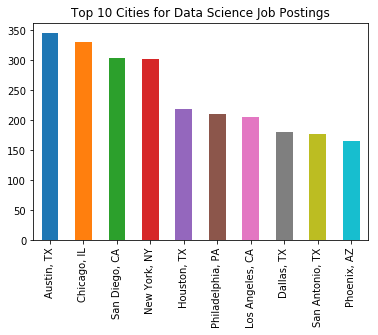

In [5]:
location = df['Location']
fig,ax = plt.subplots()
plt.title('Top 10 Cities for Data Science Job Postings')
top10locations = location.value_counts()[0:10].plot(ax=ax, kind = 'bar')

In our dataset, Austin, TX is the most common city. Next we will take those salary range estimates from glassdoor and get the projected median of the range. This takes some minor regex manipulation to pull the numbers. We will then plot the results.

In [6]:
salary = df["Salary Estimate"]
print(salary.head())

0    $111K-$181K (Glassdoor est.)
1    $111K-$181K (Glassdoor est.)
2    $111K-$181K (Glassdoor est.)
3    $111K-$181K (Glassdoor est.)
4    $111K-$181K (Glassdoor est.)
Name: Salary Estimate, dtype: object


In [7]:
salaryRangeList = []

#split on the space character to get the text range
for i in range(len(salary)):
    salaryRangeList.append(salary[i].split()[0])


salaryEstimateList = []
entryRangeList = []
for entry in range(len(salaryRangeList)):
    entrySalaryRange = []
    #for every post in the dataset, split on the dash
    post = salaryRangeList[entry]
    splitPost = post.split('-')
    for i in range(len(splitPost)):
        #search for the low and high ends of the salary range
        match = re.search(r'\d{2,3}', splitPost[i])
        entrySalaryRange.append(int(match.group()))
        
    #Then append the average and the range
    salaryEstimateList.append(statistics.mean(entrySalaryRange))
    entryRangeList.append((max(entrySalaryRange) - min(entrySalaryRange)))

Now we have a single point estimate for each job posting. We also got the range, in case we need it later. Let's throw these into a data frame with the job location and use that to plot, sorting highest to lowest

In [8]:
locationSalaryRange = {"Location":df['Location'], 
                     "Salary":salaryEstimateList,
                    "Range":entryRangeList}
LSRdf = pd.DataFrame(locationSalaryRange)
#group by location and sort by average salary estimate
print(LSRdf.groupby("Location").agg({'Salary':'mean'}).sort_values("Salary",ascending=False).head())

                      Salary
Location                    
Rockville Centre, NY  205.00
Queens Village, NY    205.00
Stanford, CA          193.50
Newark, CA            175.70
Los Gatos, CA         171.75


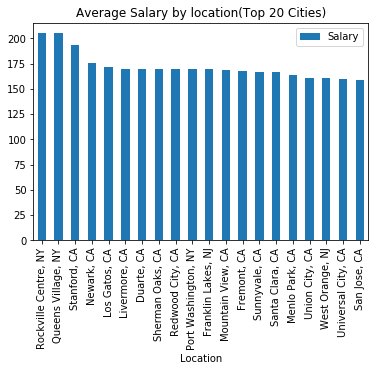

In [9]:
aggSalFrame = LSRdf.groupby("Location").agg({'Salary':'mean'}).sort_values("Salary",ascending=False).head(20)
aggSalFrame.plot.bar(title = "Average Salary by location(Top 20 Cities)")

So here we have the top salaries(in thousands) by city. The next steps I want to take are to remove cities with <30 postings in order to try to get a more statistically responsible analysis of the salaries, and maybe try a sentiment analysis/find most common skills in the job description column. Then we can try to correlate skills with salary and number of postings.

7/17/2020: Let's group salaries by state and see if that gives us a better picture. We start by doing the text split procedure on the location column. I'm going to throw the city and state in their own columns and make a dataframe with the salary info we got earlier.

In [11]:
print(location[:5])
print(salaryEstimateList[:5])

0     New York, NY
1     New York, NY
2     New York, NY
3    Lyndhurst, NJ
4     New York, NY
Name: Location, dtype: object
[146, 146, 146, 146, 146]


In [12]:
city = []
state = []
for i in range(len(location)):
    city.append(location[i].split(',')[0])
    state.append(location[i].split(',')[1])

In [13]:
salaryAndState = {"Salary":salaryEstimateList, "State":state}
salAndStateDF = pd.DataFrame(salaryAndState)

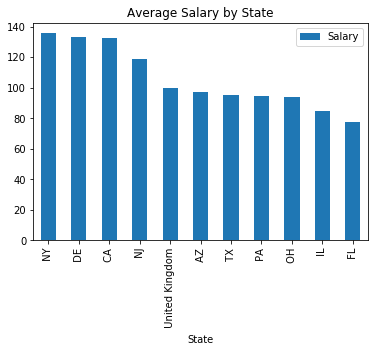

In [14]:
groupedStateDF = salAndStateDF.groupby("State").agg({'Salary':'mean'}).sort_values("Salary",ascending=False)
groupedStateDF.plot.bar(title = "Average Salary by State")

In [15]:
salAndStateDF.State.value_counts()

 TX                1253
 CA                1069
 IL                 363
 PA                 324
 NY                 313
 AZ                 295
 OH                 177
 FL                  69
 NJ                  32
 DE                  10
 United Kingdom       4
Name: State, dtype: int64

In [16]:
print((1253+1069)/3909)
print(1253/3909)

0.5940138142747505
0.3205423381939115


We only have 10 states (and the UK) represented, and almost 2/3s of the openings are in Texas and California alone. This is interesting to me, since "Data Science" seemingly saturates the online conversation about good career paths. I will have to take a look at how this was scraped. Maybe Glassdoor is just a more popular job board for companies looking for data professionals in TX and CA?

7/18/20: Let's get into some NLP with spaCy and these job descriptions. Starting with making a dataframe with the job title and description, then dealing with one posting itself.

In [17]:
title = df['Job Title']
description = df['Job Description']
titleAndDescription = pd.DataFrame([title,description]).transpose()
titleAndDescription.head()

Job Title  \
0              Senior Data Scientist   
1  Data Scientist, Product Analytics   
2               Data Science Manager   
3                       Data Analyst   
4             Director, Data Science   

                                     Job Description  
0  ABOUT HOPPER\r\n\r\nAt Hopper, we’re on a miss...  
1  At Noom, we use scientifically proven methods ...  
2  Decode_M\r\n\r\nhttps://www.decode-m.com/\r\n\...  
3  Sapphire Digital seeks a dynamic and driven mi...  
4  Director, Data Science - (200537)\r\nDescripti...

In [18]:
exampleDesc = description[1]
exampleTitle = title[1]

In [19]:
exseries = pd.Series(exampleDesc)
exTseries = pd.Series(exampleTitle)

our exseries[0] object is a string, so let's play around with the NLP package on it. We could simply split on '.' to get the sentences in a list, but I reckon spaCy has more robust solutions for the weird formatting that job descriptions sometimes have (along with ways to analyze phrases)

In [20]:
description_doc = nlp(exseries[0])
#print([token for token in description_doc])
#essentially calling .split() on the string

In [24]:
descSentences = list(description_doc.sents)
len(descSentences)

#show first 5 sentences

for sentence in descSentences[:5]:
    print(sentence)

At Noom, we use scientifically proven methods to help our users create healthier lifestyles, and manage important conditions like Type-II Diabetes, Obesity, and Hypertension.
Our Engineering team is at the forefront of this challenge, solving complex technical and UX problems on our mobile apps that center around habits, behavior, and lifestyle.


We are looking for a Data Scientist to join our Data team and help us ensure that we apply the best approaches to data analysis and research, artificial intelligence, and machine learning.


What You'll Like About Us:

We work on problems that affect the lives of real people.


In [25]:
for token in description_doc[:10]:
    print(token,token.lemma_)
        
    
#lemmatization might be useful for categorizing job expectations? will investigate later

At at
Noom Noom
, ,
we -PRON-
use use
scientifically scientifically
proven prove
methods method
to to
help help


In [26]:
#we should get rid of stop words/punctuation
#and then I think this description is prepped for analysis
description_no_stop = [token for token in description_doc
                       if not token.is_stop and not token.is_punct]
print("Non-punctuation non-stop words in description: {}".format(len(description_no_stop)))

word_freq = Counter(description_no_stop)
common_words = word_freq.most_common(15)
print(common_words)

Non-punctuation non-stop words in description: 225
[(Noom, 1), (use, 1), (scientifically, 1), (proven, 1), (methods, 1), (help, 1), (users, 1), (create, 1), (healthier, 1), (lifestyles, 1), (manage, 1), (important, 1), (conditions, 1), (like, 1), (Type, 1)]


Okay, so in this description, stripping away the punctuation and stop words gives us what looks like a list of unique words (sign of a good copywriter?). I think the power of this type of analysis is going to come from aggregating multiple descriptions, which is the next step.